# FINM33150 Quant Trading Strategy
### Alexander Popat
### Joshua Weekes
### Taylor Wood 12414926

In [15]:
library(tidyverse);
library(readxl);
library(jsonlite);
library(Quandl);
Quandl.api_key("EsFRJz6Xd3CxmytxKgCB");
source("functions_data_retrieval.R");
source("option_selection_functions.R");
source("functions_data_retrieval.R");
source("Functions/Utilities.R");
source("Functions/Generic_Methods.R");
source("Functions/Assets.R");
source("Functions/Trades.R");
source("Functions/Position.R");
source("Functions/Portfolio.R");
source("Functions/Backtest.R");
source("option_selection_functions.R");
source("Optimal_Hedge_Functions.R");
source("Functions/plotting_functions.R");
options(repr.plot.width=6, repr.plot.height=4);

In [73]:
# Data Retreival
BIZD <- Quandl.datatable('QUOTEMEDIA/PRICES', ticker = "BIZD");
HYG <- Quandl.datatable('QUOTEMEDIA/PRICES', ticker = "HYG");
XLF <- Quandl.datatable('QUOTEMEDIA/PRICES', ticker = "XLF");
IWM <- Quandl.datatable('QUOTEMEDIA/PRICES', ticker = "IWM");

load(file = "options_data.Rda");

options_data <-
  options_data %>%
    dplyr::left_join(
      dplyr::bind_rows(XLF, IWM, HYG) %>%
        dplyr::select(`ticker`, `date`, `close`) %>%
        dplyr::rename(`underlying_price` = `close`),
      by = join_by("date", "ticker"));

PD_capital_raise <-
  readxl::read_excel(
    "PitchBook_Q3_2023_Global_Private_Market_Fundraising_Report_Summary_XLS - TW.xlsx",
    sheet = "FoF fundraising",
    skip = 5,
    n_max = 2);

PD_returns <-
  readxl::read_excel(
    "Q3_2023_PitchBook_Private_Capital_Indexes_Summary_XLS_15470.xlsx",
    sheet = "Quarterly Returns",
    skip = 5) %>%
    dplyr::rename(`date` = `...1`) %>%
    dplyr::mutate(`date` = as.Date(`date`)) %>%
    dplyr::select(`date`, `Private debt`) %>%
    dplyr::filter(`date` >= as.Date("2004-12-31"));

CWBDC_data <- getCWBDCData();

New names:
• `` -> `...1`
New names:
• `` -> `...1`


## Introduction

The purpose of this strategy is to mimic the return and volatility profile of private credit funds using publicly traded Business Development Companies (BDCs). We look at the return profile of buying the BDC ETF BIZD, and buy protective option collars using options on other ETFs. The popularity and investor demand for Private Credit funds has grown tremendously over the past decade and direct lending funds have been able to raise over \$675 billion for direct lending strategies due to their relatively high returns and low volatility. While private credit is an attractive asset class for investors, private credit funds typically offer poor liquidity. Publicly traded BDCs offer similar credit exposure but with much higher liquidity due to the fact that they trade on exchanges. The additional liquidity offered by BDCs comes with higher volatility however, and look much less attractive on a risk-reward basis. By using options, we attempt to lower the volatility of a BDC investment strategy to match that of a private credit fund, while still generating similar returns. This strategy should be very attractive to current and potential private credit investors.

### The Rise of Private Credit Funds

Private credit as an asset class has attracted nearly $1 trillion in assets since the great financial crisis, as investors sought high yielding and diversifying assets. At the same time, increased financial regulation on banks required lenders to boost capital ratios, lowering their ability to make loans.

The chart below shows the cumulative capital raised in private credit funds since 2008, as measured by PitchBook. Investor demand has been especially strong despite high management and performance fees, as well as liquidity constraints. When investing in a private credit fund, capital is typically locked up for multiple years while the loans mature. On top of that, capital committed to a private credit fund is only deployed once loans are made, creating a lag between the time when an investor wants to gain exposure to private credit and when they actually do. Despite these drawbacks, investors are still willing to commit capital and pay high fees.

New names:
• `` -> `...1`


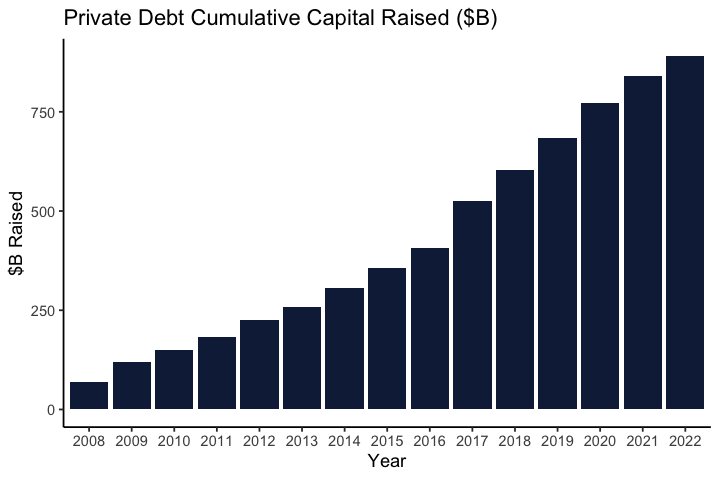

In [4]:
plot_PD_capital_raise <-
  PD_capital_raise %>%
  dplyr::rename(`metric` = `...1`) %>%
  tidyr::pivot_longer(cols = c(tidyselect::everything(), -`metric`), names_to = "year") %>%
  dplyr::filter(metric %in% "Capital raised ($B)") %>%
  dplyr::filter(!(year %in% "2023")) %>%
  ggplot() +
  aes(x = year, y = value) +
  geom_col(fill = "#112446") +
  labs(
      x = "Year",
      y = "$B Raised",
      title = "Private Debt Capital Raised ($B) by Year") +
  theme_classic();

plot_PD_capital_raise_cum <-
  PD_capital_raise %>%
  dplyr::rename(`metric` = `...1`) %>%
  tidyr::pivot_longer(cols = c(tidyselect::everything(), -`metric`), names_to = "year") %>%
  dplyr::filter(metric %in% "Capital raised ($B)") %>%
  dplyr::filter(!(year %in% "2023")) %>%
  dplyr::mutate(`value` = cumsum(`value`)) %>%
  ggplot() +
  aes(x = year, y = value) +
  geom_col(fill = "#112446") +
  labs(
      x = "Year",
      y = "$B Raised",
      title = "Private Debt Cumulative Capital Raised ($B)") +
  theme_classic();

plot_PD_capital_raise_cum;

Private credit is especially attractive to investor as an asset class because of its high single digit returns and relatively low volatility. From Q3 2004 through Q3 2024, private debt has had an average annualized return of 9.4% and an average annualized standard deviation of 8.3%, as measured by the PitchBook Private Debt Index. The chart below shows the cumulative total return of the Pitchbook Private Debt Index over that time. While this is the reported volatility that investors receive in aggregate, it is likely understated given the ability for fund managers to chose how they mark their assets. 

New names:
• `` -> `...1`


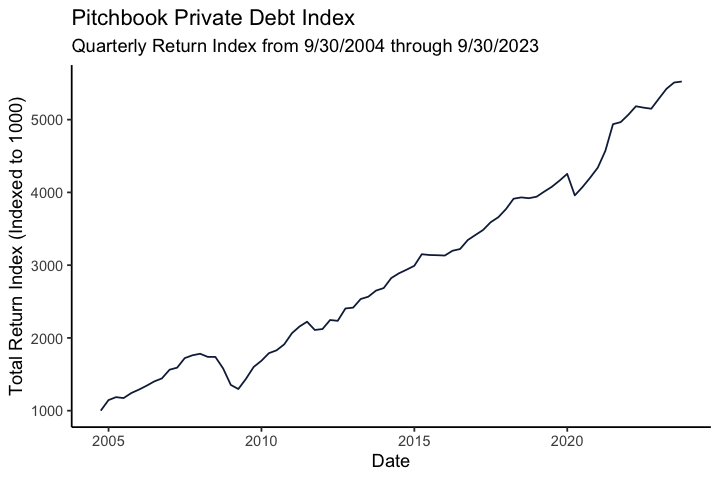

In [6]:
PD_returns <- 
  readxl::read_excel(
    "Q3_2023_PitchBook_Private_Capital_Indexes_Summary_XLS_15470.xlsx", 
    sheet = "Quarterly Returns", 
    skip = 5) %>%
  dplyr::rename(`date` = `...1`) %>%
  dplyr::mutate(`date` = as.Date(`date`)) %>%
  dplyr::select(`date`, `Private debt`) %>%
  dplyr::filter(`date` >= as.Date("2004-12-31"))

PD_ann_ret <- mean(PD_returns$`Private debt`) * 4
PD_ann_vol <- sd(PD_returns$`Private debt`) * sqrt(4)

plot_PD_index <-
  PD_returns %>%
  dplyr::mutate(`index` = cumprod(1 + `Private debt`)*1000, .keep = "unused") %>%
  dplyr::add_row(tibble::tibble_row(`date` = as.Date("2004-09-30"), `index` = 1000)) %>%
  ggplot() +
  aes(x = date, y = index) +
  geom_line(colour = "#112446") +
  labs(
    x = "Date",
    y = "Total Return Index (Indexed to 1000)",
    title = "Pitchbook Private Debt Index",
    subtitle = "Quarterly Return Index from 9/30/2004 through 9/30/2023") +
  theme_classic()

plot_PD_index

### Business Development Companies (BDCs)

Business Development Companies (BDCs) are closed end investment companies that make investments in primarily small to medium sized private companies. While BDCs can make investments across the capital structure, they tend to make first and second lien senor secured loans. In this way a BDC's investment portfolio is similar to that of a private credit fund. BDCs do not need to be publicly traded, but this analysis will only look at those that are.

BDCs are subject to certain regulatory and legal rules that impact their return profiles. As regulated investment companies (RIC), BDCs must deliver over 90% of their profits as dividends in order to avoid paying corporate tax on profits. BDCs are also limited to an asset coverage ratio of at least 200%, meaning they can leverage capital 1x.

In [8]:
# The following generates plots based on data obtained from BDCs.com
# Download CWBDC data from BDCs.com
CWBDC_data <- getCWBDCData()

# Plot the CWBDC price and total return indexes
plot_CWBDC_returns <-
  CWBDC_data %>%
  dplyr::select(`date`, `CWBDC`, `CWBDC_Price`) %>%
  dplyr::rename(
    `Total Return Index` = `CWBDC`,
    `Price Return Index` = `CWBDC_Price`) %>%
  tidyr::pivot_longer(cols = c(tidyselect::everything(), - `date`)) %>%
  ggplot() +
  aes(x = date, y = value, colour = name) +
  geom_line() +
  scale_color_hue(direction = 1) +
  labs(
    x = "Date",
    y = "Return Index Value (Starts at 1000)",
    title = "Cliffwater BDC Index: Total Return and Price Return Index",
    color = "Return Metric") +
  theme_classic()

# Plot the CWBDC dividend yield and 5 year treasury yield
plot_CWBDC_yield <-
  CWBDC_data %>%
  dplyr::select(`date`, `CWBDC_Yield`, `FiveYearTreasury`) %>%
  dplyr::rename(
    `CWBDC Index Dividend Yield` = `CWBDC_Yield`,
    `5 Year Treasury Yield` = `FiveYearTreasury`) %>%
  tidyr::pivot_longer(cols = c(tidyselect::everything(), -`date`)) %>%
  dplyr::mutate(`value` = `value` /100) %>%
  ggplot() +
  aes(x = date, y = value, colour = name) +
  geom_line() +
  scale_color_hue(direction = 1) +
  labs(
    x = "Date",
    y = "Yield",
    title = "CWBDC Index Dividend Yield and 5Yr Treasury Yield",
    color = "") +
  theme_classic()+
  scale_y_continuous(labels = scales::percent)

# Plot the volatility of NAV and Price
plot_CWBDC_vol <- 
  CWBDC_data %>%
  dplyr::select(`date`, `CWBDC_Price`, `CWBDC_NAV`, `CWBDC`) %>%
  dplyr::filter(`date` <= as.Date("2024-01-31")) %>%
  dplyr::group_by(`year` = lubridate::year(`date`), `month` = lubridate::month(`date`)) %>%
  dplyr::slice_tail(n=1) %>%
  dplyr::ungroup() %>%
  dplyr::select(-c(`year`, `month`)) %>%
  dplyr::mutate(
    `CWBDC Total Return` = `CWBDC` / lag(`CWBDC`, 1) - 1,
    `CWBDC Price Return` = `CWBDC_Price` / lag(`CWBDC_Price`, 1) - 1,
    `CWBDC Income Return` = (1+ `CWBDC Total Return`) / (1+`CWBDC Price Return`) -1,
    `CWBDC NAV Chg` = `CWBDC_NAV` / lag(`CWBDC_NAV`, 1) -1,
    .keep = "unused") %>%
  dplyr::summarise(
    `Total Return` = sd(`CWBDC Total Return`, na.rm = T) * sqrt(12),
    `Price` = sd(`CWBDC Price Return`, na.rm = T) * sqrt(12),
    `Dividend Return` = sd(`CWBDC Income Return`, na.rm = T) * sqrt(12),
    `NAV` = sd(`CWBDC NAV Chg`, na.rm = T) * sqrt(12)) %>%
  tidyr::pivot_longer(cols = tidyselect::everything()) %>%
  ggplot() +
  aes(x = `name`, y = `value`) +
  geom_col(fill = "#112446") +
  labs(
    y = "Annualized Volatility",
    x="",
    title = "Annualized Volatility") +
  theme_classic() +
  scale_y_continuous(labels = scales::percent)

plot_CWBDC_premdis_NAVchg <-
  CWBDC_data %>%
  dplyr::select(`date`, `PremDis`, `CWBDC_NAV`) %>%
  dplyr::filter(`date` <= as.Date("2024-01-31")) %>%
  dplyr::group_by(`year` = lubridate::year(`date`), `month` = lubridate::month(`date`)) %>%
  dplyr::slice_tail(n=1) %>%
  dplyr::ungroup() %>%
  dplyr::select(-c(`year`, `month`)) %>%
  dplyr::mutate(
    `Premium/Discount to NAV` = `PremDis` /100,
    `12M NAV Chg` = `CWBDC_NAV` / lag(`CWBDC_NAV`,12) - 1,
    .keep = "unused") %>%
  tidyr::pivot_longer(cols = c(tidyselect::everything(), -`date`)) %>%
  ggplot() +
  aes(x = date, y = value, colour = name) +
  geom_line() +
  scale_color_hue(direction = 1) +
  labs(
    x = "Date",
    y = "",
    color = "",
    title = "Premium/Discount to NAV and 12M Change in NAV") +
  theme_classic() +
  scale_y_continuous(labels = scales::percent) + theme(legend.position="top")


CWBDC_PD_return <-
  CWBDC_data %>%
  dplyr::select(`date`, `CWBDC_Price`, `CWBDC_Price_NAV`, `CWBDC`) %>%
  dplyr::filter(`date` <= as.Date("2024-01-31")) %>%
  dplyr::group_by(`year` = lubridate::year(`date`), `month` = lubridate::month(`date`)) %>%
  dplyr::slice_tail(n = 1) %>%
  dplyr::ungroup() %>%
  dplyr::select(-c(`year`, `month`)) %>%
  dplyr::mutate(
    `CWBDC Income` = `CWBDC` / `CWBDC_Price`,
    `CWBDC Income Return` = (`CWBDC Income`) / lag(`CWBDC Income`,1, default=1) -1,
    `CWBDC NAV Return` = `CWBDC_Price_NAV` / lag(`CWBDC_Price_NAV`, 1, default = 851.44) - 1,
    .keep = "unused") %>%
  dplyr::mutate(
    `CWBDC Income + NAV Index` = cumprod(1+ `CWBDC Income Return` + `CWBDC NAV Return`) * 1000) %>%
  dplyr::select(`date`, `CWBDC Income + NAV Index`) %>%
  dplyr::mutate(`date` = lubridate::ceiling_date(`date`, "month") -1) %>%
  dplyr::left_join(
    PD_returns %>%
      dplyr::mutate(`Private Debt Index` = cumprod(1 + `Private debt`)*1000, .keep = "unused") %>%
      dplyr::add_row(tibble::tibble_row(`date` = as.Date("2004-09-30"), `Private Debt Index` = 1000)),
    by = "date")

plot_CWBDC_PD_return_comp <-
  CWBDC_PD_return %>%
  tidyr::pivot_longer(cols = c(everything(), -`date`)) %>%
  dplyr::filter(!is.na(value)) %>%
  ggplot() +
  aes(x = date, y = value, colour = name) +
  geom_line() +
  scale_color_hue(direction = 1) +
  labs(
    x = "Date",
    y = "Return Index Value (Starts at 1000)",
    title = "BDC Dividend + NAV Returns vs Private Debt Total Return",
    color = "") +
  theme_classic()

BDC returns are primarily driven by dividend income, since at least 90% of profits must be distributed to investors as dividends. BDC book value is therefore typically only negatively impacted from credit events, since profits can not be amassed as retained earnings. The chart below shows the price return and total return of the Cliffwater BDC Index (CWBDC) indexed to 1000 since September 30, 2004. Over the past nearly 2 decades, BDCs have returned over 340%, while prices have declined 42%.

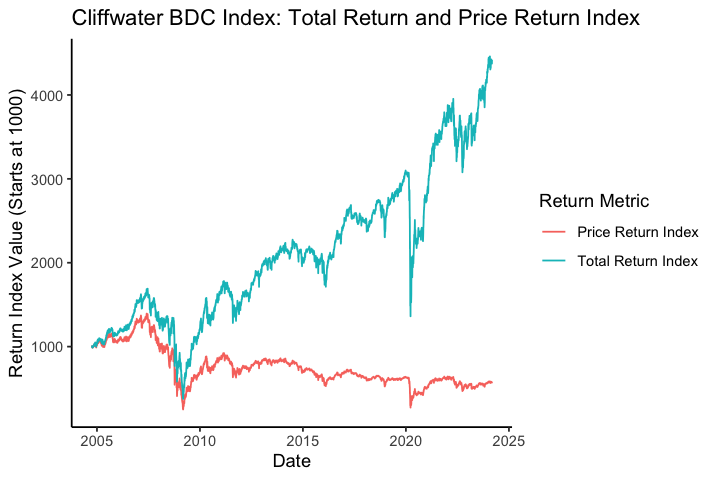

In [9]:
plot_CWBDC_returns

The chart below shows the trailing dividend yield of the Cliffwater BDC Index relative to the 5 Year Treasury Yield. The chart shows that since 2007, BDCs have had at least a high single digit dividend yield, similar to the return of private credit.

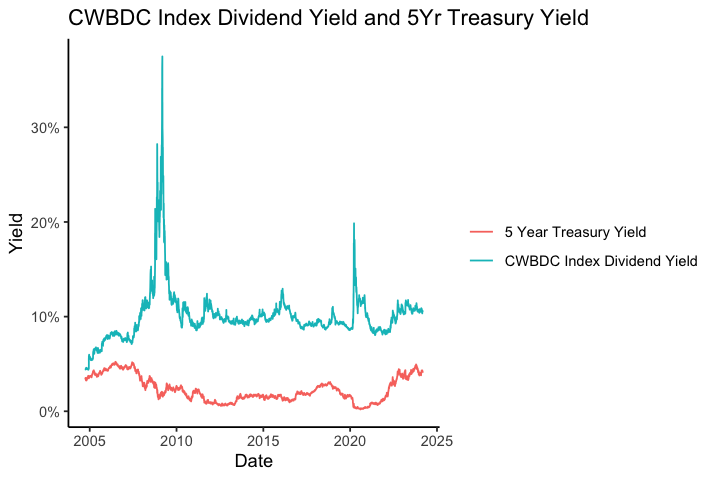

In [10]:
plot_CWBDC_yield

BDC volatility is primarily driven by changes in valuation, not the performance of their investment portfolios. The chart below shows the annualized standard deviation of the monthly dividend return, net asset value (NAV), price return and total return. Price return and total return volatility is very high at over 22%, while the volatility of the NAV is much lower at 6%, and dividend return is only 3.3%. This chart highlights that the changes in Price to NAV contribute a majority of the volatility to the total volatility profile of BDC returns.

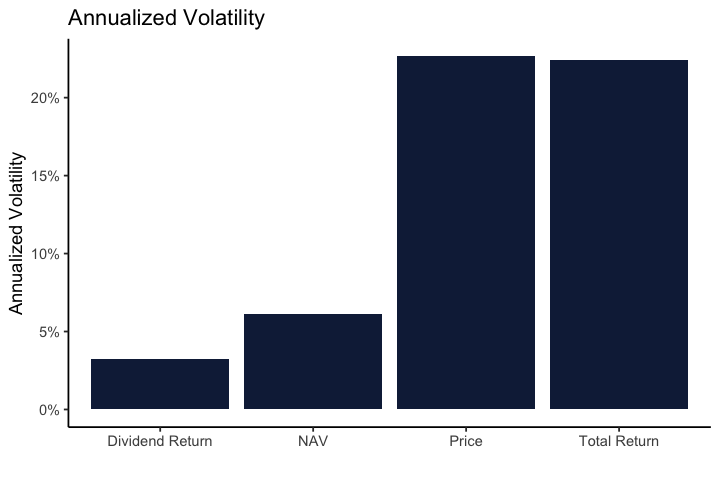

In [11]:
plot_CWBDC_vol

The change in valuation as measured by Price to NAV, which is driven by the expected changes in NAV, is typically directionally right but a much larger magnitude. The chart below shows the premium and discount to NAV of the CWBDC Index, and the 12 month change in NAV. The chart highlights the much higher volatility in Price to NAV vs the underlying volatility in NAV. For example, during the great financial crisis, the discount to NAV for BDCs reach a record low -60% (a price to NAV of merely 0.4x), while the actual NAV value decline by less than 20% on a trailing 12 month basis.

Warning message:
“Removed 12 rows containing missing values (`geom_line()`).”


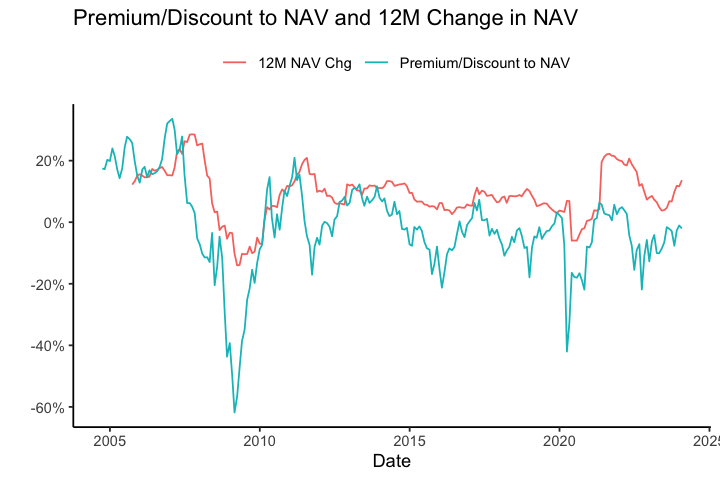

In [13]:
plot_CWBDC_premdis_NAVchg;

## The Strategy

Out strategy is to take advantage of investor's appetite for private credit exposure, but offer a liquid alternative using protective option collars on BDCs. Since BDCs are essentially publicly trade private credit vehicles, the economic exposure should be similar. Using option collars we can target the volatility levels of returns to try to match the volatility of private credit as an asset class.

This strategy seeks to reduce the volatility of investing in Business Development Companies though a BDC ETF and option collars. Employing option collars limits both the upside and downside return to the defined band between the  put option's strike less the current price and the call option's strike less the current price, by selling a call and purchasing a put option. Option collars cut the tails of the return distribution at those strike prices, and push the extreme values to the collar edges. By selling the call option, the collar strategy is cheaper than purchasing the put option alone. This is a very atratctive strategy for BDC's, since BDC returns for two reasons. First, BDC returns have histroically been negatively skewed, with more frequent small gains and a few large losses. Secondly, BDC returns have historically exhibited high levels of kurtosis, experiencing more returns around a positive mean value, with a higher concentration of extreme outliers. A well executed option collar could theoretically capture the high frequency of small positive gains, while avoiding the large drawdowns BDCs have historically experienced.

Unfortunately, publicly traded BDCs have low liquidity and almost a non-existant options market. The options that are offered on some BDCs have high bid-ask speads, and are priced with the expectation of large dividends being paid out by the underlying. Since stock prices should decline by the amount of a dividend after the ex-date (all else equal) and call option buyers are not entitled to the dividend, selling call options on high yielding securities does not generate much income, while purchasing puts can be very expensive. There is also the risk that a call option that is in the money (strike price is below current underlying price) will be exercised prior to the exercise date.

For the reasons highlighted above, low liquidiy and high cost to hedge, we are seeing to replicate option collars for BDCs by trading option collars on other securities that mimic their return profile. In order to keep the cost of the option collars as low as possible, we sought to find securities with high option volumes that economically and statistically mimic the expected returns of BDCs. Business Development Companies are small to medium market cap companies in the financials sector that are most like a portfolio of private bonds. For the strategy we used options on the iShares IBOXX $ High Yield Corporate Bond ETF (HYG), the Financial Select Sector SPDR Fund (XLF) and the iShares Russelll 2000 ETF (IWM). HYG is one of the most liquid high yield bond ETFs, comprised of a basket of U.S. high yield corporate bonds, and is ranked as the 11th highest ETF by option trading volume over the past threee months. XLF is highly traded ETF comprised of a basket of U.S. stocks in the financial sector, and is ranked the 9th highest ETF by trading volume over the past three months. IWM is highly traded ETF comprised of a basket of 2000 small-cap U.S. companies and is ranked the 10th highest ETF by option trading volume. For the strategy we will buy the VanEck BDC Income ETF (BIZD) to gain BDC exposure. 


### BIZD
To gain exposure to BDC securities, the strategy will go long the VanEck BDC Income ETF (BIZD), the largest and most liquid BDC ETF offered. According to VanEck, BIZD "seeks to replicate s closelt as possible, before fees and expense, the price and yield performance of the MVIS US Business Development Companies Index (MVDBCTRG), which tracks the overall performance of publicly traded business development companies." As of March 7th 2024, total net assets in BIZD were $946 million.

The chart below shows the performance for BIZD since Feb 12th 2013. While very volatile, the ETF returned an average annual return of over 8%, and returned over 92% cumulatively.
 

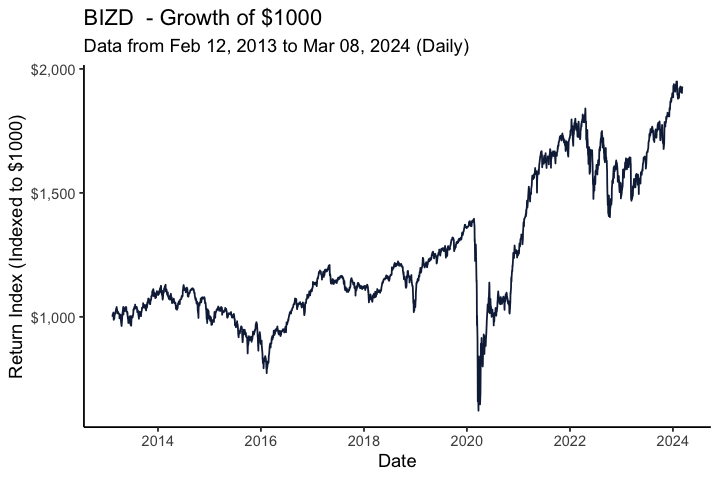

In [74]:
BIZDPlots <- makeReturnPlots("BIZD", BIZD, "date", "adj_close")
BIZDPlots$index_plots[["Daily"]]

The output below shows return statistics for BIZD since 2/12/2023. As the table shows, BIZD is a very volatile investment product, with an annualized return standard deviation of 20.7%, giving it a sharpe ratio of only 0.391. Returns are negatively skewed, and have very fat tails. The max drawdown, experience during the height of the Covid-19 pandemic, was -55.5%. This is a far cry from the very smooth and stable returns that private credit investors have received.

In [70]:
cat(BIZDPlots$summary[["Daily"]], sep ="\n")

Total Return:		72.1%
Ann. Mean Returns:	10.4%
Ann. Return Vol:	23.6%
Sharpe Ratio (no rf):	0.44
Sortino Ratio (no rf):	0.647
Skewness:		-0.72
Excess Kurtosis		37.6
Max Drawdown:		-55.5%


The histograms below show the return distribution of BIZD using daily, weekly, and monthly return frequencies. As the summary statistics highlighted above, the returns are are very peaked, with long tails. Interestingly, the longer the time horizon the less Leptokurtic the distribution is. As we will show below, BIZD returns are autocorrelated. Most interest

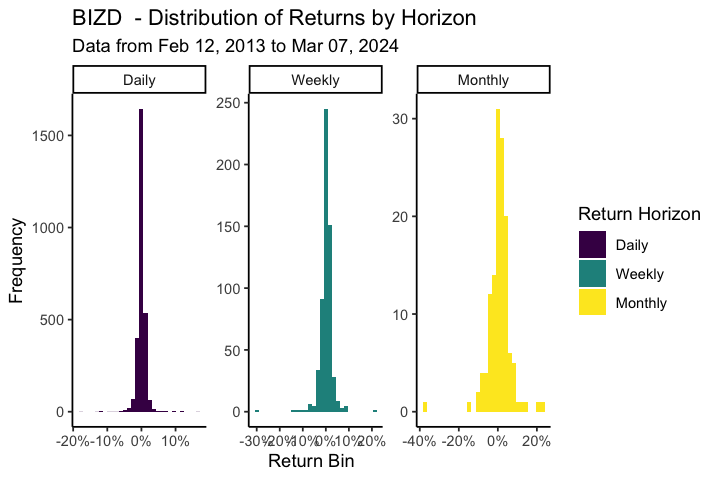

In [35]:
BIZDPlots$hist_plot_all

The QQ plot below shows the quantiles of returns for a given return horizon vs the theortetical quantiles of a normal distribution. The further confirms the heavy-tailed nature of BIZD returns, and that the shorter horizon returns have heavier tails than the longer horizon returns.

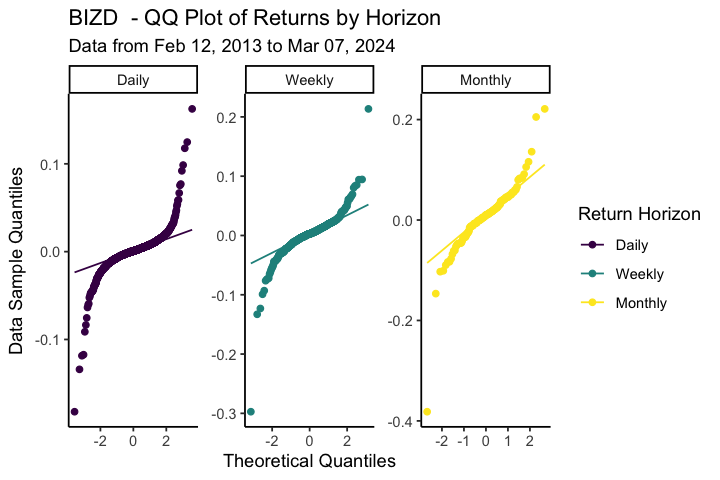

In [38]:
BIZDPlots$qq_plot_all

The plots below show the autocorrelation and partial autocorrelation functions for different BIZD's return horizons. The plots tell an intereting story, with the daily returns showing serveral autocorrelatons that are significant at the 95% confidence interval, with what appears to short term positive autocorrelation followed by a longer period of negative autocorrelation. On a monthly basis, there appears to be more short term negative autocorrelation, indicating a mean-reverting nature to the returns. The mean reverting nature of returns is consitent with our view that BDC stock prices tend to get over sold relative to the actual credit impact to the assets. This divergence in price relative to the health of loans is a major contributor to the relative volatility vs private credit funds, which do not mark their books as frequently.

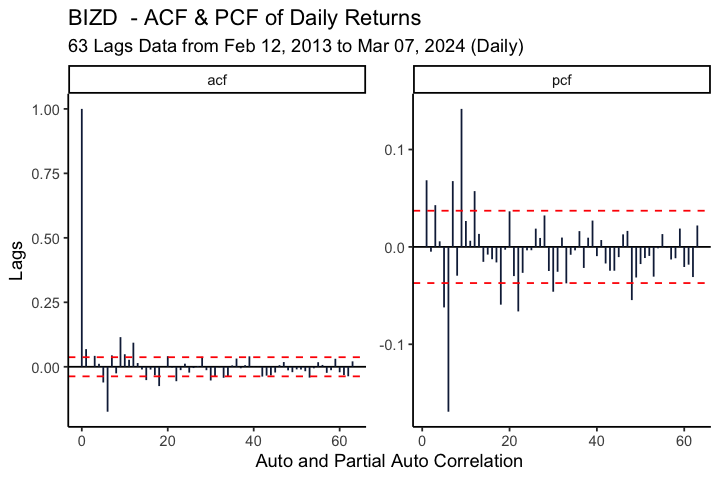

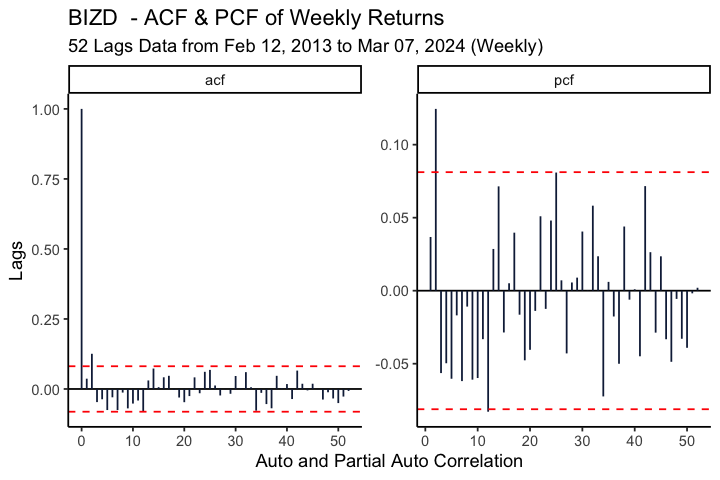

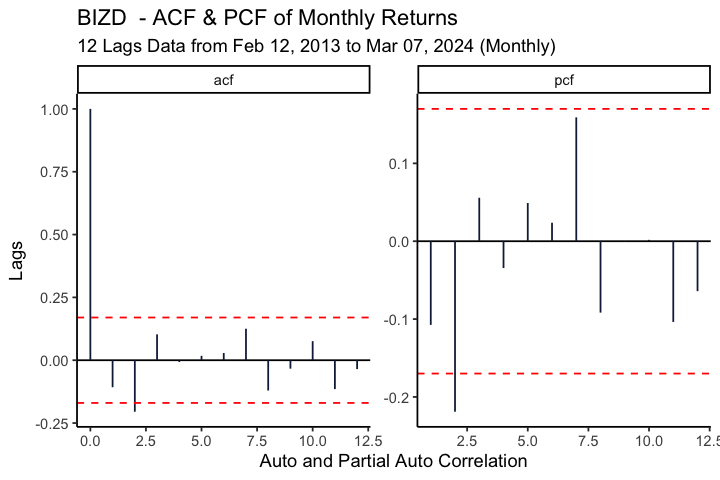

In [51]:
BIZDPlots$acfpcf_plots$Daily
BIZDPlots$acfpcf_plots$Weekly
BIZDPlots$acfpcf_plots$Monthly

The next chart below shows the periodic returns by return horizon for BIZD. The charts show that at shorter return horizons, BIZD returns exhibit autoregressive conditional heteroskedasticity.

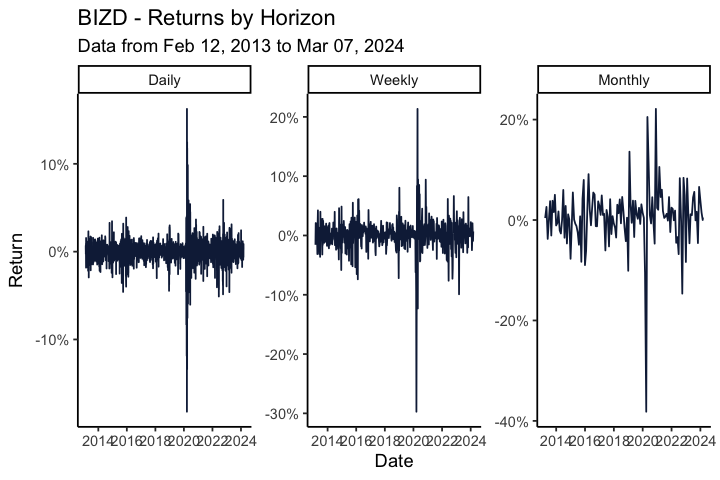

In [52]:
BIZDPlots$return_plot_all

### HYG
The iShares IBOXX $ High Yield Corporate Bond ETF (HYG) makes economic sense as a potential hedging asset to BIZD, beacuse it is a portfolio of high yielding bonds, and the assets held by BDCs are primarily high yielding private bonds.

Since August 11,2007, HYG has had an annualized average return of 5.02%, with an average annualized standard deviation of 11.4%. Like BIZD, HYG has high excess kurtosis, but has positive skew.

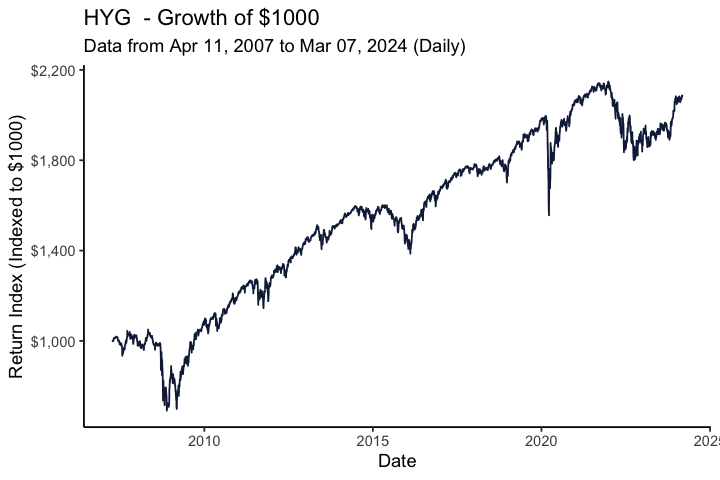

In [58]:
HYGPlots <- makeReturnPlots("HYG", HYG, "date", "adj_close")
HYGPlots$index_plots[["Daily"]]

In [59]:
cat(HYGPlots$summary[["Daily"]], sep ="\n")

Total Return:		 109%
Ann. Mean Returns:	5.02%
Ann. Return Vol:	11.4%
Sharpe Ratio (no rf):	0.439
Sortino Ratio (no rf):	0.686
Skewness:		0.78
Excess Kurtosis		39.7
Max Drawdown:		-34.2%


Similar to BIZD, HYG's QQ plot shows the high kurtosis, which lowers as the return horizon increases.

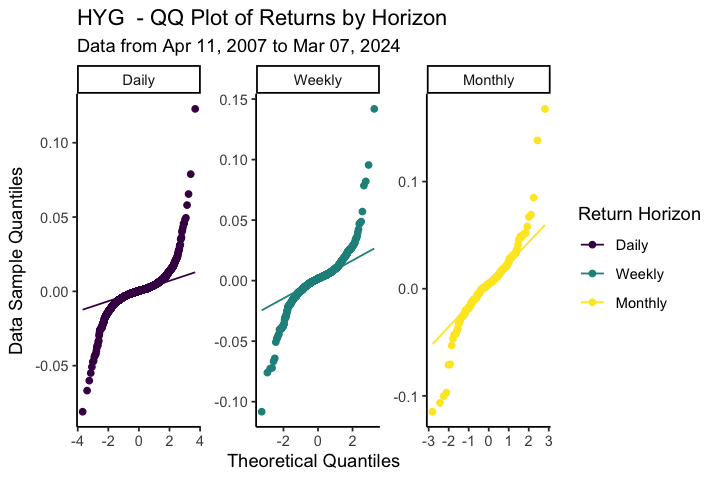

In [76]:
HYGPlots$qq_plot_all

The plot below shows the QQ plot of BIZD vs HYG. 

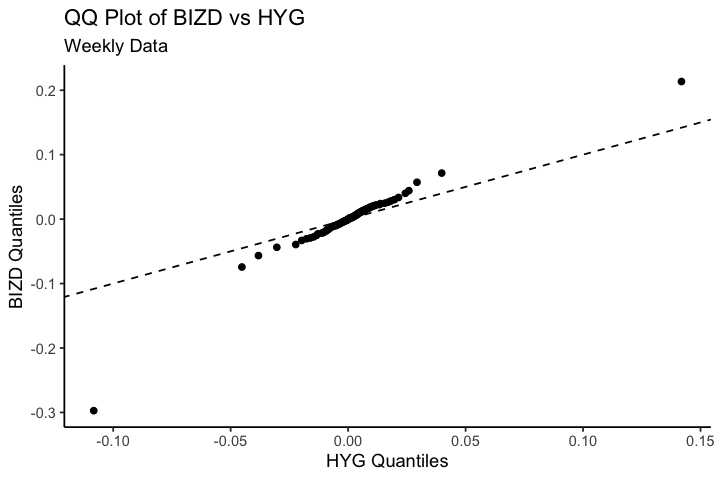

In [89]:
plot_2_qq(c("BIZD", "HYG"), list(BIZDPlots$data$Weekly, HYGPlots$data$Weekly), "Weekly")

The chart below shows the rolling 63 day correlation of BIZD and HYG returns. Over the time frame, the correlation varied from slightly below 0 to nearly, reaching a high during the Covid-19 pandemic.

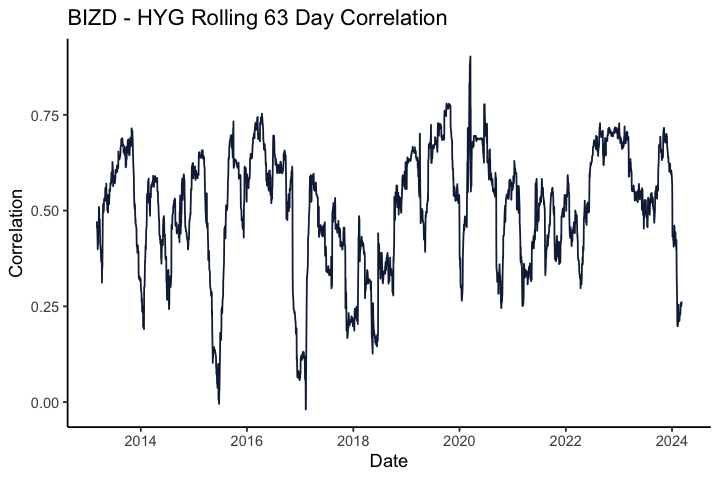

In [91]:
plot_roll_corr(c("BIZD", "HYG"), list(BIZDPlots$data$Daily, HYGPlots$data$Daily), "Day", 63)

The plot below shows the periodic returns by return horizon for HYG. While the returns for HYG do seems to have volatiltiy clustering, it should be noted that the volatiltiy was much lower in magnitude than BIZD during the pandemic. In fact, BIZD's extreme moves during the pandemic where greater than HYG's during the GFC.

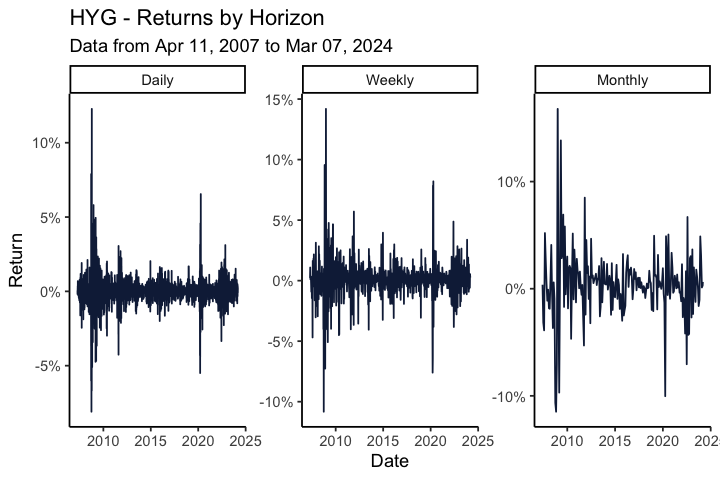

In [108]:
HYGPlots$return_plot_all

## Finding the Optimal Linear Exposure Weights
The first step in building our strategy is to identify the target exposures to HYG, IWM, and XLF that replicate the performance of BIZD. In the optimistic case that we can find the allocation to HYG, IWM, and XLF that perfectly mimicks the performance of BIZD, then an option collar on that replication portfolio will act as an option collar on BIZD.

As Sharpe (1992) showed with his mutual-fund decomposition, linear regression can be used to find the appropriate exposures to the replicating assets that minimizes the difference in returns from BIZD. In the linear regression equation below, each Beta coefficient equates the optimal linear exposure to that asset to replicate the return of BIZD.



The regression coefficients are entirely dependent of the covariance and expected values used in the regression. We looked at four different methods to calculate the covariance and expected value used to generate the optimal linear exposure, including equally weighted returns with expanding window, equally-weighed returns with box window, exponentially weighted returns with expanding window, and dynamic condiditional correlation multivariate generalized autoregressive conditional heteroskedasticity DCC-MGARCH with expanding window. The main differences amongst the four methods are the window of historical returns, and the model for generating the expectred return and covariance. With the expanding window, the model is exposed to all historical data as of that point in time. In the box window, as new data becomes available, historical data is removed so that the model is exposed to a constant number of historical data points. In the equally-weighted model, all historical returns data is given the same weight. In the exponentially weighted model, more recent data is given a higher weight. In the DCC-MGARCH model, expected returns are modeled with an ARMA model, and the covariance matrix is modeled with an MGARCH model.

In [95]:
Option_Dates <- options_data %>%
  dplyr::filter(ticker == "HYG") %>%
  dplyr::arrange(`exdate`) %>%
  dplyr::filter(between(`exdate`, as.Date("2017-12-31"), as.Date("2023-12-31"))) %>%
  dplyr::pull(`exdate`) %>%
  unique()

ETF_adj_close  <- 
  purrr::imap(
    list("BIZD" = BIZD, "HYG" = HYG, "XLF" = XLF, "IWM" = IWM),
    \(x, idx) x %>%
      dplyr::select(., `date`, `adj_close`) %>%
      dplyr::rename(!!idx := `adj_close`) %>%
      expandDate()) %>%
  purrr::reduce(\(a,b) inner_join(a,b, by = "date")) %>%
  dplyr::arrange(`date`) %>%
  dplyr::mutate(`weekday` = weekdays(`date`)) %>%
  tidyr::nest(`adj_close` = c(everything(), -`weekday`), .by = `weekday`) 

ETF_Weekly_LNReturns <- 
  ETF_adj_close$adj_close %>%
  purrr::map(function(x){
    x %>%
      dplyr::mutate(
        dplyr::across(c(dplyr::everything(), -`date`), \(x) log(x) - lag(log(x)))) %>%
      slice(-1)}) %>%
  dplyr::bind_rows() %>%
  dplyr::arrange(`date`)
    
ETF_Weekly_Returns <- 
  ETF_adj_close$adj_close %>%
  purrr::map(function(x){
    x %>%
      dplyr::mutate(
        dplyr::across(c(dplyr::everything(), -`date`), \(x) x /lag(x) -1)) %>%
      slice(-1)}) %>%
  dplyr::bind_rows() %>%
  dplyr::arrange(`date`)


Optimal_Weights <- 
  dplyr::left_join(
    tidyr::nest(ETF_Weekly_LNReturns, `return_lnweekly` = c(everything(), -`date`), .by ="date"),
    tidyr::nest(ETF_Weekly_Returns, `return_weekly` = c(everything(), -`date`), .by ="date"),
    by = "date") %>%
  dplyr::arrange(`date`) %>%
  dplyr::filter(between(`date`,as.Date("2013-12-31"), as.Date("2023-12-31"))) %>%
  dplyr::group_by(weekdays(`date`)) %>%
  dplyr::mutate(
    `expanding_return` = purrr::accumulate(`return_lnweekly`, bind_rows),
    `box_return_52` = purrr::accumulate(`return_lnweekly`, roll_bind, 52)) %>%
  dplyr::ungroup() %>%
  dplyr::filter(`date` %in% Option_Dates) %>%
  # Find next option date & calc trading days until
  dplyr::mutate(
    `nxt_date` = lead(`date`, 1),
    `fwd` = purrr::map2(`date`, `nxt_date`, \(x,y) min(7,as.numeric(y-x)) - 2)) %>%
  # Calculate the optimal weights
  dplyr::mutate(
    `BIZD_only_weights` = purrr::map(`return_weekly`, lo_weights, y = "BIZD"),
    `ols_expand_weights` = purrr::map(`expanding_return`, ols_weights, fwd = 1, y = "BIZD", lamda = 1),
    `ols_expand_exp_weights` = purrr::map(`expanding_return`, ols_weights, fwd = 1, y = "BIZD", lamda = 0.9),
    `ols_box_weights` = purrr::map(`box_return_52`, ols_weights, fwd = 1, y = "BIZD", lamda = 1),
    `mgarch_weights` = purrr::map(`expanding_return`, mgarch_weights, fwd = 1, y = "BIZD"))


Optimal_Weights_Returns <-
  Optimal_Weights %>%
  # Calculate the returns from the target portfolio
  dplyr::mutate(
    dplyr::across(
      tidyselect::contains("_weights"),
      ~purrr::map2(`return_weekly`, lag(.x, 1), hedgefit), 
      .names = "{.col}_hedge_return")) %>%
  dplyr::rename_with(~stringr::str_remove(.x, "_weights"), .cols=tidyselect::contains("hedge_return")) %>%
  # Calculate the returns from the target portfolio with perfect costless collar
  dplyr::mutate(
    dplyr::across(
      c(tidyselect::contains("_weights"), -contains("BIZD")),
      ~purrr::map2(`return_weekly`, lag(.x, 1), hedgefit_collar, collar_moneyness = c(.99, 1.01)), 
      .names = "{.col}_collar_return")) %>%
  dplyr::rename_with(~stringr::str_remove(.x, "_weights"), .cols=tidyselect::contains("collar_return")) %>%
  dplyr::select(c(`date`, tidyselect::contains("hedge_return"), tidyselect::contains("collar_return"))) %>%
  tidyr::unnest(tidyselect::everything())


#### Equally-Weighted Return with Expanding Window
For the first optimal weights model we chose a simple, equally-weighted linear regression, with an expanding data set. The first returns data begins 

The chart below show the exposure weights for HYG, IWM, and XLF to replicate BIZD returns using equally-weighted expanding historical returns. The weights assigned to IWM and XLF remainded fairly stready over the testing period. The weight to HYG increased dramatically during the pandemic.This makes sense, as the correlation chart above showed the correlation of HYG to BIZD spiking during the pandemic, but the increase in volatiltiy was not nearly as large.

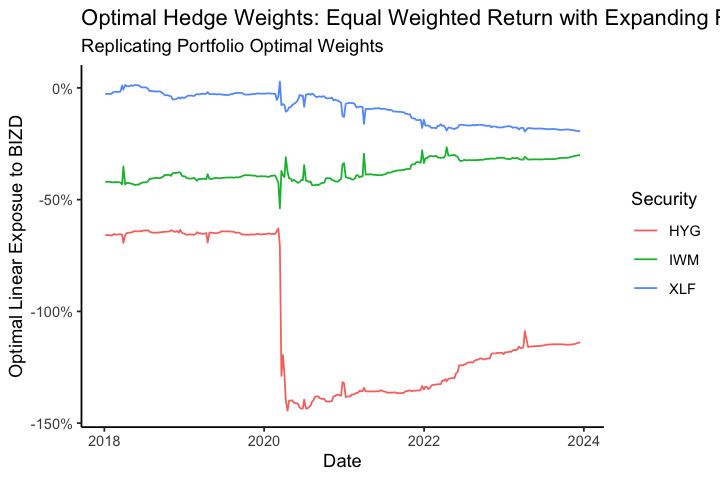

In [107]:
source("Functions/plotting_functions.R");
plot_optimal_hedge_weights(Optimal_Weights, "ols_expand_weights", name = "Equal Weighted Return with Expanding Return")

The chart below is the histogram of residual returns from the hedging portfolio.

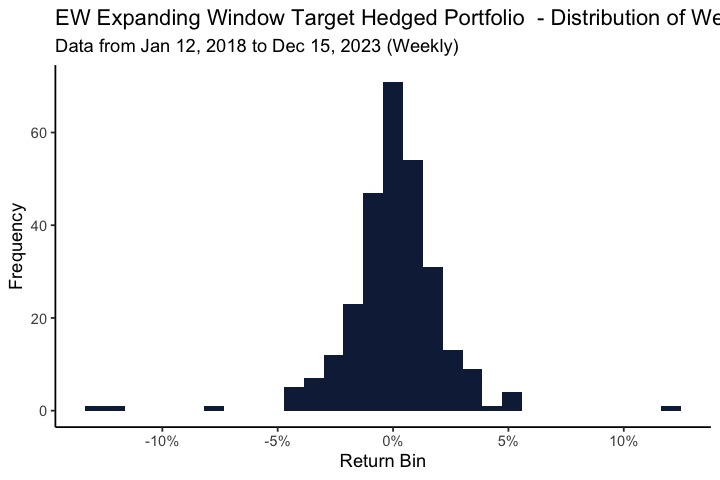

In [110]:
EWExpTgtPlots <- makeReturnPlots(
    name = "EW Expanding Window Target Hedged Portfolio",
    data = data.frame(
        "date" = as.Date(Optimal_Weights_Returns$date),
        "return" = Optimal_Weights_Returns$ols_expand_hedge_return),
    datecol = "date",
    returncol = "return")
EWExpTgtPlots$hist_plots$Weekly

#### Exponentially Weighted Return with Expanding Window

#### Equally-Weighted Return with Box Window

#### DCC-GARCH with Expaninding Window

## Setting Options Positions
Once the optimal linear exposure weights have been determined, the next step is find the options to build the collar strategies on the underlying. Since the strategy is traded weekly on weekly option expiration dates, trades tends to be on Fridays, although sometimes this occurs on Thursdays. Since the strategy is not based on trading options prior to expiration, we seek to set the notional exposure of the long option leg equal to the notional amount of BIZD in the portfolio time the optimal weight and notioanl exposure of the short leg equal to the negative notional amount of BIZD in the portfolio. 

The model we developed takes into account the descrete nature of option strike prices, buy purchasing the options with strike prices immediatly above and below our target strike price. The model weights the two options so that the weighted average strike price is equal to our target strike price.

In [ ]:
sub_options_data <- options_data %>%
  dplyr::filter(`date` %in% as.Date(Optimal_Weights$date))

# Find the option ids to be traded
Option_trade_ids <- Optimal_Weights %>%
  dplyr::filter(`date` <= as.Date("2023-01-27")) %>%
  dplyr::select(`date`, `nxt_date`, `mgarch_weights`) %>%
  dplyr::mutate(
    `options` = purrr::pmap(
      list(`mgarch_weights`, `date`, `nxt_date`),
      option_collar,
      data = sub_options_data,
      tgt_mny = c(.99, 1.01),
      buy_only = F))

Option_trades_symbols <- Option_trade_ids %>%
  dplyr::select(`options`) %>%
  tidyr::unnest(tidyselect::everything())

# Subset the options data to just the ones we need and make them an asset object
Option_Assets <- options_data %>%
  dplyr::filter(`symbol` %in% Option_trades_symbols$option) %>%
  tidyr::nest(`option_data` = everything(), .by = `symbol`) %>%
  dplyr::mutate(`option_asset` = map(`option_data`, WRDSOption, .progress=T)) %>%
  dplyr::select(`symbol`, `option_asset`)

# Create the trade target list
Option_trades_list <-
  Option_trade_ids %>%
  dplyr::select(`date`, `nxt_date`, `options`) %>%
  tidyr::unnest(tidyselect::everything()) %>%
  tidyr::nest(`weight` = `weight`, .by = c(`date`, `nxt_date`, `option`)) %>%
  dplyr::filter(`nxt_date` < as.Date("2023-02-04")) %>%
  dplyr::left_join(Option_Assets, by = c("option" = "symbol")) %>%
  dplyr::mutate(`weight` = map(`weight`, \(x) x)) %>%
  dplyr::mutate(
    `open_trade` = purrr::pmap(
      list(`option_asset`, `date`, `weight`), 
      newTradeTarget, 
      target_type = "Open"),
    `close_trade` = purrr::pmap(
      list(`option_asset`, `nxt_date`, `weight`),
      newTradeTarget,
      target_type = "Close")) %>%
  dplyr::mutate(
    `no_yield` = purrr::map(`open_trade`, \(x) x@cost == 0 & x@side == "Sell")) %>%
  dplyr::filter(`no_yield` == F)

# Create the Opening BIZD Purchase
BIZD_trade_target_open <- newTradeTarget(
  QuandlEquity("BIZD", BIZD), 
  trade_date = as.Date("2018-01-05"),
  target_amount = 1,
  target_type = "Open",
  side = "Buy")

trade_targets <- Option_trade_targets + BIZD_trade_target_open

In [ ]:
dates <- as.Date(names(BIZD_asset@close)) %>%
dates <- sort(dates[which(dates >= min(opt_dates) & dates <= max(opt_dates))])
initial.capital <- 1000000
transaction.cost <- 0.001
BT <- backtestTradeTargets(dates, trade_targets, cash_rates = 0, transaction.cost = 0.001)